In [1]:
using NetCDF, Elefridge, ZfpCompression
using PyPlot, FileIO, JLD2
using StatsBase, Statistics
ticker = PyPlot.matplotlib.ticker

path = "/network/aopp/chaos/pred/kloewer/esowc/"
member1files = filter(x->endswith(x,".nc"),readdir(joinpath(path,"member1")))
steps = [parse(Int,split(split(file,"step")[2],".")[1]) for file in member1files]
sort!(steps)

# parameter
Nens = 25
Nbits = 32
Nlon = 1800
Nlat = 901
Nvert = 91
Nsteps = length(steps);

In [28]:
function CRPS!(x::Array{T,1},o::T) where T
    sort!(x)
    n = length(x)
    dp = 1/n                                # probability increment per xi in x

    # find index m to split integration over x into heaviside=0 or 1
    m = findfirst(xi -> xi >= o,x)   
    
    # integration from o to x if o is outside of the range of x
    s = m==1 ? x[1]-o : 0.0                 

    # integrate over the heaviside=0 part
    for i in 1:(m == nothing ? n-1 : m-1)
        s += (i*dp)^2*(x[i+1]-x[i])
    end

    # integrate over the heaviside=0 part
    for i in (m == nothing ? n : m):n-1
        s += (i*dp-1)^2*(x[i+1]-x[i])
    end

    
    s += (m == nothing) ? o-x[end] : 0.0

    return s
end

CRPS(x::Array{T,1},o::T) where T = CRPS!(copy(x),o)

CRPS (generic function with 1 method)

In [3]:
# load one file for lon,lat indices
ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step0.ll.nc"))
lon = ncfile.vars["lon"][:]
lat = ncfile.vars["lat"][:];

In [4]:
place0 = (0.0,51.5)
x0,y0 = findmin(abs.(lon .- place0[1]))[2],findmin(abs.(lat .- place0[2]))[2];

In [13]:
# t = fill(0f0,Nens,Nsteps)  # original time series
# t4d = fill(0f0,Nens,4,4,4,Nsteps)

for it in 1:Nsteps
    print("$it,")
    for ie in 1:Nens
        s = steps[it]
        file = joinpath(path,"member$ie","ensemble.t.member$ie.step$s.ll.nc")
        t[ie,it] = NetCDF.ncread(file,"t",start=[x0,y0,Nvert,1],count=[1,1,1,1])[1]
        t4d[ie,:,:,:,it] = NetCDF.ncread(file,"t",start=[x0,y0-2,Nvert-3,1],count=[4,4,4,1])[:,:,:]
    end
end

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,

In [5]:
filepath = joinpath(path,"analysis","london.jld2")
# save(filepath,"t",t,"t4d",t4d)
t,t4d = load(filepath,"t","t4d");
size(t4d)

(25, 4, 4, 4, 145)

In [6]:
x = hcat(round(t[:,1:34],8),round(t[:,35:102],7),round(t[:,103:end],6));

In [7]:
z = zero(x)

for ie in 1:Nens
    z[ie,1:34] = zfp_decompress(zfp_compress(t4d[ie,:,:,:,1:34],precision=13))[1,3,4,:]
    z[ie,35:102] = zfp_decompress(zfp_compress(t4d[ie,:,:,:,35:102],precision=12))[1,3,4,:]
    z[ie,103:end] = zfp_decompress(zfp_compress(t4d[ie,:,:,:,103:end],precision=11))[1,3,4,:]
end

In [33]:
tm = mean(t,dims=1)[1,:]
tm = t[3,:]

crps_x = zero(tm)
crps_z = zero(tm)

for i in 1:Nsteps
    crps_x[i] = CRPS(x[:,i],tm[i])
    crps_z[i] = CRPS(z[:,i],tm[i])
end    

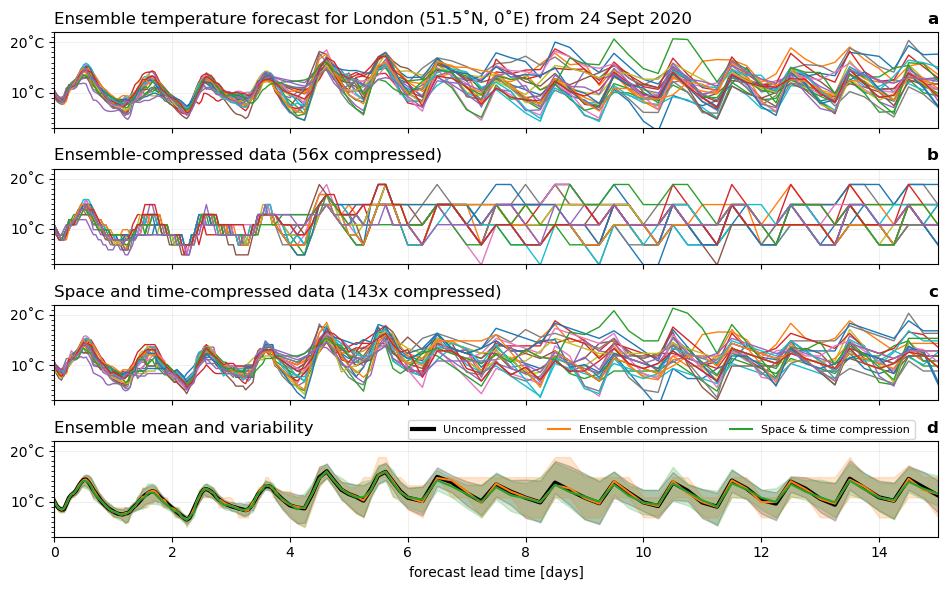

In [36]:
days = steps/24

fig,(ax1,ax2,ax21,ax3) = subplots(4,1,figsize=(10,6),sharex=true,sharey=true)

k = 273.15

# ensemble
ax1.plot(days,t' .- k,lw=1)
ax2.plot(days,x' .- k,lw=1)
ax21.plot(days,z' .- k,lw=1)

# mean and variability
ax3.plot(days,mean(t' .- k,dims=2),"k",lw=3,label="Uncompressed")
ax3.plot(days,mean(x' .- k,dims=2),"C1",lw=1.5,label="Ensemble compression")
ax3.plot(days,mean(z' .- k,dims=2),"C2",lw=1.5,label="Space & time compression")

ax3.fill_between(days,[percentile(t[:,i].-k,10) for i in 1:Nsteps],
                      [percentile(t[:,i].-k,90) for i in 1:Nsteps],
                     color="k",alpha=0.2)
ax3.fill_between(days,[percentile(x[:,i].-k,10) for i in 1:Nsteps],
                      [percentile(x[:,i].-k,90) for i in 1:Nsteps],
                     color="C1",alpha=0.2)
ax3.fill_between(days,[percentile(z[:,i].-k,10) for i in 1:Nsteps],
                      [percentile(z[:,i].-k,90) for i in 1:Nsteps],
                     color="C2",alpha=0.2)

# ax4.plot(days,crps_x,"C1")
# ax4.plot(days,crps_z,"C2")

ax3.legend(loc=(.4,1.02),ncol=3,fontsize=8)

ax1.set_yticks(1:25,minor=true)
ax1.set_xlim(0,15)
ax1.set_ylim(3,22)


ax3.set_xlabel("forecast lead time [days]")
ax1.set_title("Ensemble temperature forecast for London (51.5˚N, 0˚E) from 24 Sept 2020",loc="left")
ax2.set_title("Ensemble-compressed data (56x compressed)",loc="left")
ax21.set_title("Space and time-compressed data (143x compressed)",loc="left")
ax3.set_title("Ensemble mean and variability",loc="left")

for (iax,ax) in enumerate([ax1,ax2,ax21,ax3])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d˚C"))
    ax.grid(alpha=0.2)
    ax.set_title(string(Char(96+iax)),loc="right",fontweight="bold")
end

tight_layout()
savefig("../plots/ensemble_forecast.png")